# NequIP Tutorial

Simon Batzner, Albert Musaelian, Lixin Sun   
Contact: batzner@g.harvard.edu

This is an introduction to the NequIP code. It will cover: 

- how to work with equivariant networks in general and e3nn
- how to build a NequIP model 
- how to load a data set 
- how to train a model 
- I/O in NequIP
- how to predict with a trained model

In particular, we will build two types of models. 

- A model that predicts potential energy and obtains forces via backprop as the negative gradient of the energy 
- A model that predict positions

### Requirements

To run this tutorial, you will need the same requirements as the general NequIP code, outlined in the README.md. We assume you have read the NequIP paper (https://arxiv.org/abs/2101.03164) and have some understanding of what an equivariant networks (we recommend: https://arxiv.org/abs/1802.08219 and https://arxiv.org/abs/1807.02547)

## Equivariant Networks and the ```Irreps``` class

Before we can dive into how NequIP works, we need to understand a little bit about how to translate the theory of equivariant networks into code, in particular the ```e3nn``` (https://e3nn.org/) code that NequIP uses under the hood for building equivariant networks. 

The key parameters for building different networks are irreducible representations (https://en.wikipedia.org/wiki/Irreducible_representation) used inside the network, a term from group representation theory, which itself is a metho to describe group theory in the language of linear algebra. The fundamental class that describes the irreducible representations is the ```Irrep``` class (singular) in ```e3nn```, representing the irreducible representations of $O(3)$ and describing how features in NequIP behave under rotations and mirrors. 



The ```Irreps``` class (plural) combines different ```Irrep``` objects, in particular it constitutes a direct sum of representations. For example, a direct sum of $D_1$, $D_2$, and $D_3$ can be written this like this: 


$$
D_1 \oplus D_2 \oplus D_3 = \begin{bmatrix} D_1 & 0 & 0 \\ 0 & D_2 &  0  \\ 0 & 0 & D_3\end{bmatrix}
$$

This is the fundamental class we work with to build different networks. It is therefore worth our time to understand a bit better what it contains. A typical set of irreps in NequIP or e3nn has the following form:

Irreps: ```mxlp```, where 

* ```m``` is the multiplicity, i.e. the number of features
* ```x``` simply stands for times 
* ```l``` is the rotation order (describing whether our internal features are scalars, vectors, ...) 
* ```p``` describes the parity, where we have two choices: even or odd, ```e``` or ```o```, which describes how the tensor transforms under mirrors. An example of building a set of 16 vectors with odd parity would thus be:  ```16x1o```


For our purposes, we use the irreps to describe all features inside our network, the most important of which are: 

a) the set of hidden, internal features inside the network, given by ```feature_irreps_hidden```. Here are a few examples: 

* an invariant, SchNet-type network with only scalar interactions and 32 features: ```32x0e```
* an equivariant network with l = {0, 1} and without parity as used in the NequIP paper: ```32x0e + 32x1e```
* an equivariant network with l = {0, 1, 2} and with parity: ```32x0o + 32x0e + 32x1o + 32x1o + 32x2o + 32x2e```

b) the irreps for the spherical harmonics expansion of the edges, given by ```irreps_edge_sh```, i.e. how the interatomic vectors transform under symmetry. These are given simply as ```Irreps``` with multiplicity $1$ and increasing $l$. If you want to include parity-equivariance, you have to make sure to alternate the parity of the irreps since $(-1)^l$ gives alternative even/odd behavior. If you are not interested in using parity-equivariance, just use even parities: 

* parity-equivariant irreps up to l=2: ```1x0e + 1x1o + 1x2e```
* irreps without parity equivariance up to l=2: ```1x0e + 1x1e + 1x2e```

c) the output of the network. For example, predicting an even scalar (such as a potential energy), would be an Irrep of ```1x0e```, a vector would be ```1x1o``` (vector have odd parity). 

### Side note on parity and pseudoscalars/-vectors/-tensors

In addition to scalars, vectors, tensors, the ```Irreps``` also include a description on parity, i.e. the behavior under mirrors. Parity is best explained via the example of a vector and a pseudovector. As an example of a vector, we will choose a force acting on atom (top image below), as an example of a pseudovector, we will choose the magnitic field $\vec{B}$ (bottom image below, image source: https://en.wikipedia.org/wiki/Pseudovector). In both visualizions, the structure is mirrored from the left (source) to the right (target). 

The *vectors* in the top image transform as we would expect, i.e. they flip sign in the x dimension. 

In contrast, the B-field in the bottom image constitutes a *pseudo-vector*, that means it gains an additional sign under an inversion. If we were to just mirror the B-field lines, we would get the wrong answer. 

Mathematically, this is rooted in the cross product. To show this, let $R$ be a matrix representation of an improper rotation, i.e. a composition of a mirror and (potentially) a rotation, acting on vector $x \in X$ such that $x' = Rx$. We know that improper rotations have $det(R) = -1$. 

We also know that for $R$, the following always holds for the cross product $\times$: 

$$
R(x_a)R(x_b) = det(R)R(x_a \times x_b)
$$

Therefore if we let $R$ act on $x_a$, $x_b$, we get for the cross product under an improper rotation: 

$$
x_c' = x_a' \times x_b' = (Rx_a) \times (Rx_b) = det(R)R(x_a \times x_b) = det(R)x_c
$$

and since $det(R) = -1$, we see that under the cross product, $x_c'$ picks up an additional sign. Therefore, we can say that a cross product of two vectors gives a pseudo-vector. 

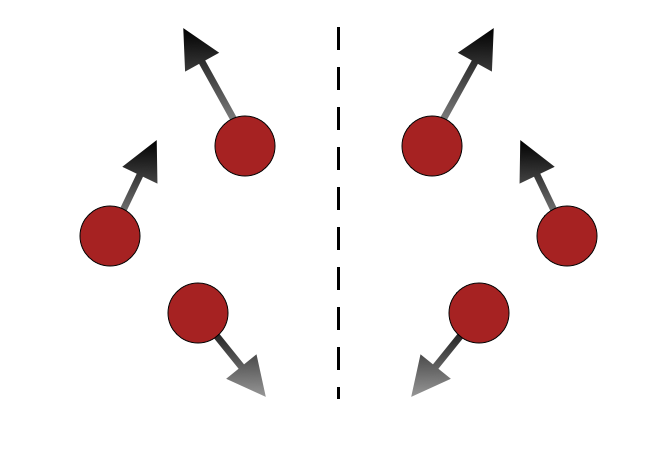

In [1]:
from IPython.display import Image
Image(filename="parity.png", width = 600, height = 300)

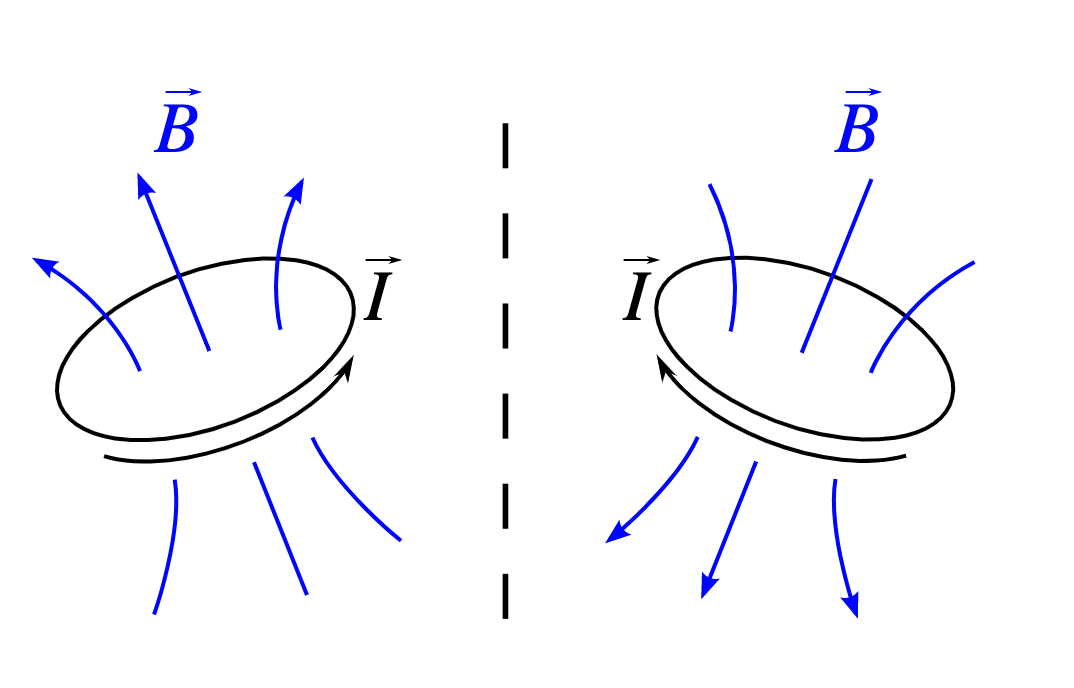

In [2]:
Image(filename="pv.png", width = 650, height = 300)

### Design choices

Now is also a good time to discuss how to choose the irreps. In general, we have found that going from $l=0 \rightarrow l=1$ gives a massive improvement. Going from $l=1 \rightarrow l=2$ further improves performance significantly. Going from $l=2 \rightarrow l=3$ further improves it, but after that we start to see a diminishing return on investment (our primary investment here is memory).  

We also find that adding parity can significantly boost prediction. To design a network without parity, we would choose the ```e``` parity for all states (hidden features and spherical harmonics). To design networks *with* parity, we alternatve the irreps on the spherical harmonics, for example ```1x0e + 1x1o + 1x2e```, and to construct all possible paths, we use both ```e``` and ```o``` irreps in the hidden features, for example ```32x0o + 32x0e + 32x1o + 32x1o + 32x2o + 32x2e```

However, adding higher order ```l```s and parity increases the memory footprint of the model as well as inference time. It therefore represents a tradeoff between accuracy and efficiency. For many systems, we found going up to $l_{max}=2$ with parity (as described above) a good choice, and a feature representation of 16 or 32 to be enough. If you can afford it, we were able to achieve our best results with $l_{max} = 3$, parity and a feature dimension of 32. To construct an equivariant network all you need is a $l_{max} = 1$ network. This is a key hyperparameter you will need to optimizer however.  

Let's try to translate some of this into code. We can build Irreps using the ```o3.Irreps``` class in e3nn: 

First, let's just create a different ```Irrep``` for different geometric quantities, in particular we will build: 

* a scalar: $l=0$, $p=e$
* a pseudoscalar: $l=0$, $p=o$ (https://en.wikipedia.org/wiki/Pseudoscalar)
* a vector: $l=1$, $p=o$
* a pseudovector: $l=1$, $p=e$ (https://en.wikipedia.org/wiki/Pseudovector)

In [1]:
import torch
from e3nn import o3

scalar_irrep = o3.Irrep('0e')
pseudo_scalar_irrep = o3.Irrep('0o')
vector_irrep = o3.Irrep('1o')
pseudo_vector_irrep = o3.Irrep('1e')

In [2]:
scalar_irrep

0e

In [3]:
vector_irrep

1o

Next, let's take a look at a direct sum of representations, in particular we'll build a direct sum of irreps consisting of a scalar and 2 vector: $0 \oplus 1 \oplus 1$: 

In [4]:
irreps = o3.Irreps('1x0e + 2x1o')

In [5]:
irreps

1x0e+2x1o

As expect, these have a maximum ```l``` of $1$

In [6]:
irreps.lmax

1

We can also easily iterate over the ```l```s and ```p```s: 

In [7]:
[(l, p) for l, p in irreps]

[(1, 0e), (2, 1o)]

To explain how the ```Irreps``` transform, we will repeat here a very nice visualization from the ```e3nn``` tutorial (https://docs.e3nn.org/en/latest/index.html), written by Mario Geiger. For the full documentation, please see their great tutorial. We will just repeat the most important parts here: 

We start by constructig two ```Irreps```, $D_X = 2 x 1o$ (two odd vectors) and $D_Y = 1 x 0e + 1 x 1e$ (one scalar and one pseudovector). 

In [8]:
irreps_x = o3.Irreps('2x1o')
irreps_y = o3.Irreps('0e + 1e')

Note that the ```Irreps``` themselves don't contain data but just describe the representation. Let's fill them with random data. As we suspect, the dimensions are $2 \times 3 = 6$ ($3$ elements in a $l=1$ vector) and $1 \times 1 + 1 \times 3$ (one scalar, one pseudovector). 

In [9]:
x = irreps_x.randn(-1)
y = irreps_y.randn(-1)

irreps_x.dim, irreps_y.dim

(6, 4)

The outer product of these two tensors is a $6 \times 4$ tensor

In [10]:
A = torch.einsum('i,j', x, y)
A

tensor([[-1.4555,  0.3107,  0.3016,  0.9660],
        [ 4.3486, -0.9282, -0.9010, -2.8861],
        [ 0.6122, -0.1307, -0.1268, -0.4063],
        [-0.9475,  0.2022,  0.1963,  0.6289],
        [ 1.1119, -0.2373, -0.2304, -0.7379],
        [-3.0166,  0.6439,  0.6250,  2.0020]])

If we rotate this tensor, it will rotate the way the tensor production representation $D_X \otimes D_Y$ rotates: 

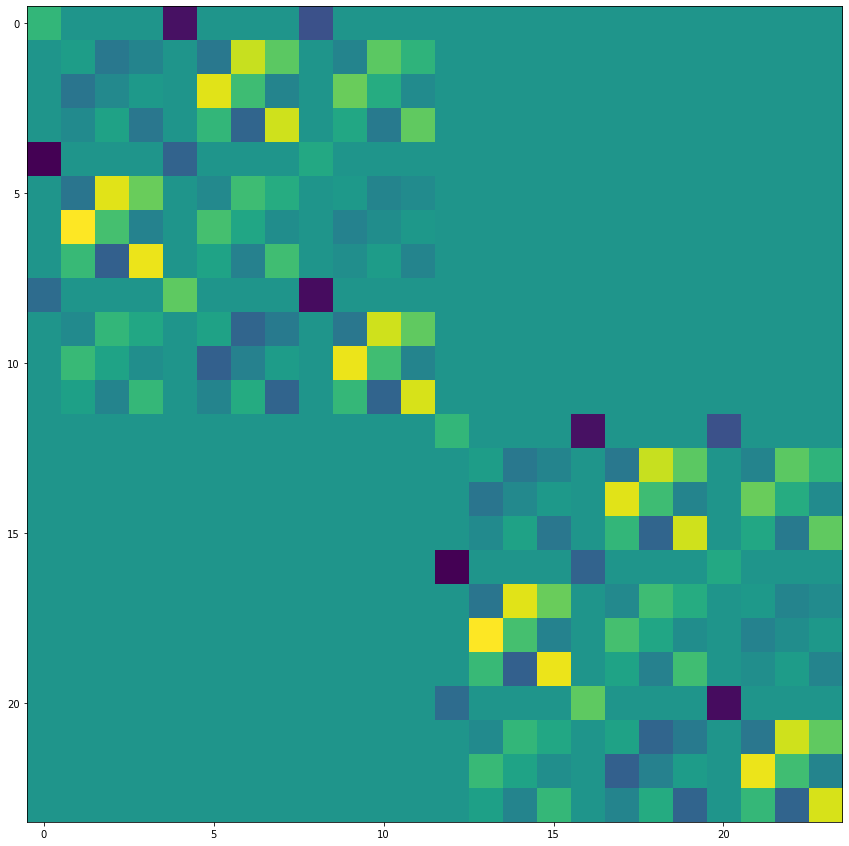

In [11]:
R = o3.rand_matrix()
D_x = irreps_x.D_from_matrix(R)
D_y = irreps_y.D_from_matrix(R)

from matplotlib import pyplot as plt
plt.figure(figsize=(15, 15))
plt.imshow(torch.kron(D_x, D_y));

Note however, that this tensor product representation is now not an irreducible representation. However, we can transform it back into a direct sum of irreducible representation via a change-of-basis matrix (see Clebsch-Gordan coefficients for more detail). The ```FullTensorProduct``` in ```e3nn``` takes care of this automatically. Note that if we print it, it describes the two input irreps, and the output irreps, which has already been transformed into a direct sum of irreps. 

In [12]:
tp = o3.FullTensorProduct(irreps_x, irreps_y)
print(tp)

FullTensorProduct(2x1o x 1x0e+1x1e -> 2x0o+4x1o+2x2o | 8 paths | 0 weights)


Finally, we can compute the Tensor Product and visualize it. Note that the final structure of the visualization matches the output ```Irreps```: 

* $2 \times l=0$ scalars
* $4 \times l=1 $ vectors
* $2 \times l=2$ tensors

In [13]:
tp(x, y)

tensor([-0.5754,  1.1396, -1.4555,  4.3486,  0.6122, -0.9475,  1.1119, -3.0166,
        -1.9511, -0.7755,  0.8696, -0.9637,  0.0106,  0.3066,  0.5907, -0.4431,
        -0.6966, -2.1305, -0.5070,  0.9000, -0.0290, -1.0880, -0.0799,  1.2727])

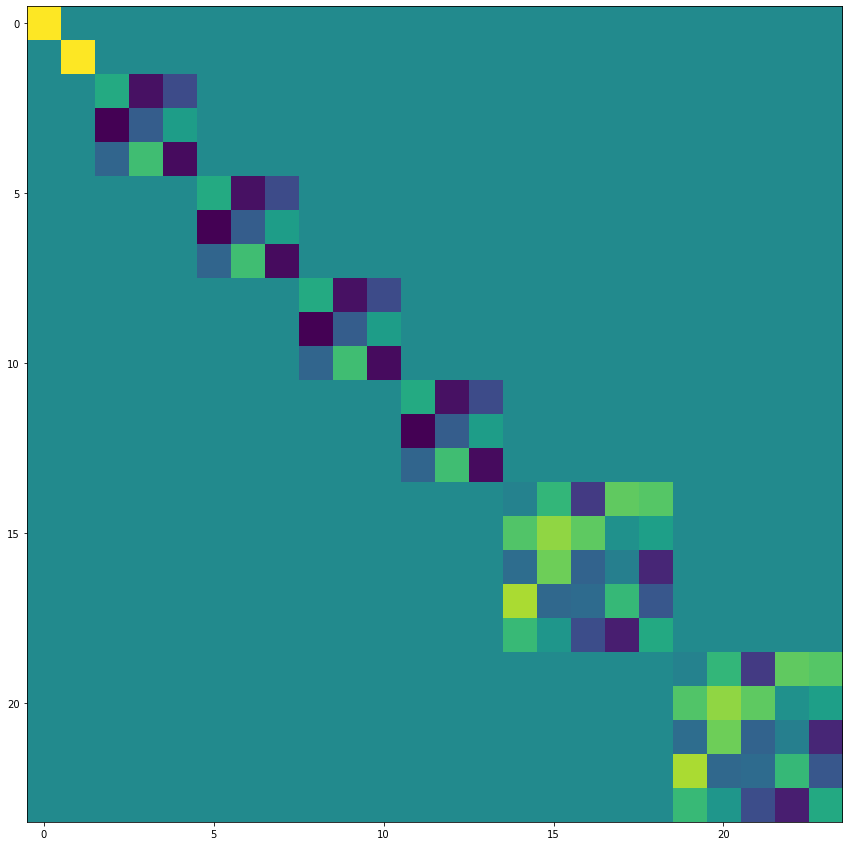

In [14]:
D = tp.irreps_out.D_from_matrix(R)
plt.figure(figsize=(15,15))
plt.imshow(D);

# NequIP

After learning about the ```Irreps``` and ```e3nn```, we are ready to ues NequIP. We will outline input to the code, how to build a network, how to load data, the interface to ```pytorch_geometric```, as well as training and predicting with a network. 

Let's start with a clean directory. 

In [17]:
!rm -rf ./results/
!rm -rf ./tutorial_data

We use float32 as our default type. If you care about very high equivariance precision, set it to torch.float64.

In [18]:
import torch
torch.set_default_dtype(torch.float32)

## Input

Input to the code works easiest via a config file. This directory contains a tutorial.yaml file with an extensive set of inputs. You will not need all of these, but they cover most of what you might need at some point. Now might be a good time to take a quick look at that file. 

In [19]:
from nequip.utils import Config
config = Config.from_file('./tutorial.yaml')

Let's take a quick look at what is inside our config. Many of these are self-explanatory such as batch size of dataset, but there are a few key parameters to be aware of and we will go through the most important ones here: 

In [20]:
import pprint
pprint.pprint(config.as_dict())

{'BesselBasis_trainable': True,
 'PolynomialCutoff_p': 6,
 'append': False,
 'atomic_weight_on': False,
 'batch_size': 1,
 'compile_model': True,
 'conv_to_output_hidden_irreps_out': '8x0e',
 'dataset': 'npz',
 'dataset_file_name': './tutorial_data/benzene_ccsd_t-train.npz',
 'feature_irreps_hidden': '8x0o + 8x0e + 8x1o + 8x1e',
 'irreps_edge_sh': '0e + 1o',
 'key_mapping': {'E': 'total_energy',
                 'F': 'forces',
                 'R': 'pos',
                 'z': 'atomic_numbers'},
 'learning_rate': 0.01,
 'log_batch_freq': 5,
 'log_epoch_freq': 1,
 'loss_coeffs': {'forces': 1.0, 'total_energy': 0.0},
 'lr_scheduler_name': 'CosineAnnealingWarmRestarts',
 'lr_scheduler_params': {'T_0': 10000,
                         'T_mult': 2,
                         'eta_min': 0,
                         'last_epoch': -1},
 'max_epochs': 25,
 'n_train': 25,
 'n_val': 5,
 'nonlinearity_type': 'gate',
 'npz_fixed_field_keys': ['atomic_numbers'],
 'num_basis': 8,
 'num_layers': 3,
 'opti

## Logging

Outputs in NequIP include human-readable logfile, numpy-readablel logfiles and most importantly the saved moel files as well as a series of modules used for restarting an interrupted training run. All of these outputs are stores in the directory specified by 'root'/'project' in your config. 

In [21]:
from nequip.utils import Output
import logging
output = Output.from_config(config)
config.update(output.as_dict())
logging.info(f"Set logging...")

Set logging...


We use the tool Weights&Biases for model and metrics logging, to get an account go here: https://wandb.ai/
This is optional however, everything works perfectly fine without, just be sure to set ```wandb: false ``` in your config file. We can now instantiate a Trainer object, which will take care of training as well as a series of callback functions for model saving, logging, early stopping. 

In [22]:
if config.wandb:
    from nequip.train.trainer_wandb import TrainerWandB
    trainer = TrainerWandB(model=None, **dict(config))

else:
    from nequip.train.trainer import Trainer
    trainer = Trainer(model=None, **dict(config))

Torch device: cpu
* Initialization
append: false
atomic_weight_on: false
batch_size: 1
end_of_batch_callbacks: []
end_of_epoch_callbacks: []
end_of_train_callbacks: []
exclude_keys: []
final_callbacks: []
init_callbacks: []
kwargs:
  BesselBasis_trainable: true
  PolynomialCutoff_p: 6
  compile_model: true
  conv_to_output_hidden_irreps_out: 8x0e
  dataset: npz
  dataset_file_name: ./tutorial_data/benzene_ccsd_t-train.npz
  feature_irreps_hidden: 8x0o + 8x0e + 8x1o + 8x1e
  irreps_edge_sh: 0e + 1o
  key_mapping:
    E: total_energy
    F: forces
    R: pos
    z: atomic_numbers
  logfile: null
  nonlinearity_type: gate
  npz_fixed_field_keys:
  - atomic_numbers
  num_basis: 8
  num_layers: 3
  optimzer_params:
    amsgrad: true
    betas: !!python/tuple
    - 0.9
    - 0.999
    eps: 1.0e-08
    weight_decay: 0
  r_max: 4.0
  resnet: false
  screen: false
  wandb: false
  workdir: ./results/tutorial/tutorial
learning_rate: 0.01
loader_params: null
log_batch_freq: 5
log_epoch_freq: 1
lo

## Dataloaders

Next, let's load some data. For this tutorial, we will use a data set of Benzene MD-data. We will train on 10 configurations, sampled from an AIMD trajectory at T=500K and computed at CCSD(T) accuracy. We have positions, chemical species, potential energies, and forces. 

In [23]:
!mv benzene*.xyz ./tutorial_data
!rm *.zip

zsh:1: no matches found: benzene*.xyz
zsh:1: no matches found: *.zip


In [24]:
!curl http://quantum-machine.org/gdml/data/npz/benzene_ccsd_t.zip -o outfile.zip
!unzip outfile.zip
!rm -rf __MACOSX outfile outfile.zip
!rm -rf ./tutorial_data
!mkdir tutorial_data
!mv benzene* tutorial_data
!curl http://quantum-machine.org/gdml/data/xyz/benzene_ccsd_t.zip -o ourfile.zip
!unzip outfile.zip
!curl http://quantum-machine.org/gdml/data/xyz/benzene_ccsd_t.zip -o outfile.zip
!unzip outfile.zip
!mv benzene*.xyz ./tutorial_data
!rm *.zip
!ls tutorial_data

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  823k  100  823k    0     0   603k      0  0:00:01  0:00:01 --:--:--  603k
Archive:  outfile.zip
  inflating: benzene_ccsd_t-train.npz  
   creating: __MACOSX/
  inflating: __MACOSX/._benzene_ccsd_t-train.npz  
  inflating: benzene_ccsd_t-test.npz  
  inflating: __MACOSX/._benzene_ccsd_t-test.npz  
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  809k  100  809k    0     0   702k      0  0:00:01  0:00:01 --:--:--  702k
unzip:  cannot find or open outfile.zip, outfile.zip.zip or outfile.zip.ZIP.
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  809k  100  809k    0     0   636k      0  0:00:01  0:00:01 --

Let's visualize what we just downloaded: 

In [25]:
from ase.io import read
atoms = read('./tutorial_data/benzene_ccsd_t-train.xyz', index=0)

In [26]:
from ase.visualize import view
view(atoms, viewer='x3d')

In [27]:
from nequip.utils import dataset_from_config
dataset = dataset_from_config(config)
logging.info(f"Successfully loaded the data set of type {dataset}...")

Processing...


Loaded data: Batch(batch=[12000], cell=[1000, 3, 3], edge_cell_shift=[113786, 3], edge_index=[2, 113786], forces=[12000, 3], pbc=[1000, 3], pos=[12000, 3], ptr=[1001], total_energy=[1000])
Successfully loaded the data set of type NpzDataset(1000)...


Done!


## Normalization

Next, we normalize the targets we train to. We subtract the mean from the potential energies and scale both energies and forces by the standard deviation of the forces across all flattened force components. Note that you may never reduce the mean of the forces in a model that computes forces as the gradient of a potential energy as this will break equivariance. 

In [28]:
from nequip.data import AtomicDataDict

In [29]:
(
    (forces_std),
    (energies_mean, energies_std),
    (allowed_species, Z_count),
) = dataset.statistics(
    fields=[
        AtomicDataDict.FORCE_KEY,
        AtomicDataDict.TOTAL_ENERGY_KEY,
#         AtomicDataDict.ATOMIC_NUMBERS_KEY,
    ],
    modes=["rms", "mean_std", "count"],
)


In [30]:
trainer.set_dataset(dataset)

## Building a network to predict Energies and Forces

Finally, we are ready to build a model. We will start by building a model for energies and conservative forces. This will consist of two steps:

1. First, we will build a model that predict the potential energy, an invariant scalar, computed as a sum over atomic energies

2. In a second step, we compute the atomic forces as the negative gradient of our energy-network, yielding energy-conserving and rotation-equivarint forces. 

We have pre-built networks for energy + forces which you can just import as shown below or as used in ```train.py``` for example:   

In [2]:
from nequip.models import EnergyModel, ForceModel

energy_model_ = EnergyModel(allowed_species=allowed_species, **dict(config))
force_model_ = ForceModel(energy_model)

To show you how to build your own models, however, in this tutorial we will explicitly build our own networks. Note that to simplye use NequIP for energy/force prediction tasks, all you need to change is your config file and ```train.py```, we will cover here in case you want to tweak the networks / design your own. 

We build the model using the class ```SequentialGraphNetwork```, a class that build a network through a ```Sequential``` of layers, all of which input and output a graph. The ```from_parameters``` method of this class takes two inputs: 

1. ```share_params```, a dictionary containing the model parameters used in various parts of the code
2. ```layers```, a dictionary containing a set of layers in the order in which they will be appended. 

Let's run through the layers: 

* ```OneHotAtomicEncoding```: we start by embedding atomic numbers (e.g. 6, 1 C, H) into one-hot features
* ```SphericalHarmonicEdgeAttr```: the spherical harmonics embedding of interatomic vectors
* ```RadialBasisEncoding```: a basis embedding of interatomic distances, we use the Bessel Basis in particular, together with a smooth cutoff function that makes sure atoms enter inside the cutoff sphere in a continuous fashion
* ```AtomiwiseLinear```, in particular one we use for our initial atom embedding: ```AtomwiseLinear``` layers act independent but with shared weights on all atoms in the system, i.e. they do not communicate information between atoms. These are the equivariant equivalent of a Dense layer. We use this first layer to take us from the space of species one-hots (2 scalar in the case of Benzene, representing C and H) into the feature space, in our case we only use the even scalars of hidden irrpes, so here ```8x0e```
* ```ConvNet```: this is a series of interaction blocks as described in the NequIP paper. It contains the most fundamental operations of the network, including the equivariant convolution and tensor products. 
* another ```AtomwiseLinear```, this time labeled ```conv_to_output_hidden```, this takes us from the final even scales of the convolution to an intermediate representation in the output block. This is simply an intermediate step to reduce the feature dimension, e.g. from 32 --> 8 
* a final ```AtomwiseLinear```, this time labeled ```output_hidden_to_scalar```, this takes us from the feature rpesentation to the single scalar output which we interpret as the atomic potential energy
* ```AtomwiseReduce```, a simple sum over atomic outputs, this gives us the total predict potential energy, a sum over atomic potential energies. 

In [31]:
import logging

from nequip.data import AtomicDataDict
from nequip.nn import (
    SequentialGraphNetwork,
    AtomwiseLinear,
    AtomwiseReduce,
    GradientOutput,
    ConvNet,
)
from nequip.nn.embedding import (
    OneHotAtomEncoding,
    RadialBasisEdgeEncoding,
    SphericalHarmonicEdgeAttrs,
)

from nequip.nn.radial_basis import BesselBasis
from nequip.nn.cutoffs import PolynomialCutoff
from nequip.utils import instantiate


def EnergyModel(allowed_species, **kwargs):
    """
    A model that predicts total energy.

    Example input for each class
      - OneHotAtomEncoding {'allowed_species': array([1, 6, 8]), 'num_species': None, 'set_features': True}
      - SphericalHarmonicEdgeAttrs {'set_node_features': False, 'l_max': 1}
      - RadialBasisEdgeEncoding {'basis': BesselBasis(), 'cutoff': PolynomialCutoff()}
      - AtomwiseLinear {'field': 'node_features', 'out_field': None, 'irreps_out': '1x0e'}
      - ConvNet {'convolution': <class 'nequip.nn._interaction_block.InteractionBlock'>, 'num_layers': 2,
        'resnet': False, 'nonlinearity_type': 'norm', 'nonlinearity_kwargs': {},
        'feature_irreps_hidden': '16x0o + 16x0e + 16x1o + 16x1e + 16x2o + 16x2e',}
      - AtomwiseLinear
        {'field': 'node_features', 'out_field': None, 'irreps_out': '1x0e'}
    """

    logging.debug("Start building the network model")

    share_params = dict(allowed_species=allowed_species, **kwargs)

    # select the parameters needed for BesselBasis
    basis, _ = instantiate(
        cls_name=BesselBasis,
        prefix="BesselBasis",
        all_args=share_params,
    )
    cutoff, _ = instantiate(
        cls_name=PolynomialCutoff,
        prefix="PolynomialCutoff",
        all_args=share_params,
    )

    return SequentialGraphNetwork.from_parameters(
        shared_params=share_params,
        layers={
            # -- Encode --
            "one_hot": OneHotAtomEncoding,
            "spharm_edges": SphericalHarmonicEdgeAttrs,
            "radial_basis": (
                RadialBasisEdgeEncoding,
                dict(
                    basis=basis,
                    cutoff=cutoff,
                ),
            ),
            # -- Embed features --
            "feature_embedding": AtomwiseLinear,
            # -- ConvNet --
            "convnet": ConvNet,
            # -- output block --
            "conv_to_output_hidden": AtomwiseLinear,
            "output_hidden_to_scalar": (
                AtomwiseLinear,
                dict(irreps_out="1x0e", out_field="atomic_energy"),
            ),
            "total_energy_sum": (
                AtomwiseReduce,
                dict(
                    reduce="sum",
                    field="atomic_energy",
                    out_field=AtomicDataDict.TOTAL_ENERGY_KEY,
                ),
            ),
        },
    )


We can now use the ```energy_model``` we just built as an input to a ```GradientOutput``` module. This will act on the ```energy_model``` in a sequential manner, using the output of ```energy_model``` as its input. We specify what we take the gradient of, the argument with respec to which we compute the gradient, and in this case also the sign as forces are the negative gradient of the potential energy. We also specify the input irreps (i.e. those of the potential energy, a scalar) and the irreps of the gradient argument, i.e. those of the atomic position, a vector quantity. 

In [32]:
def ForceModel(energy_model):

    return GradientOutput(
        func=energy_model,
        of=AtomicDataDict.TOTAL_ENERGY_KEY,
        wrt=AtomicDataDict.POSITIONS_KEY,
        out_field=AtomicDataDict.FORCE_KEY,
        irreps_in={
            AtomicDataDict.TOTAL_ENERGY_KEY: "1x0e",
            AtomicDataDict.POSITIONS_KEY: "3x0e",
        },
        sign=-1,  # force is the negative gradient
    )

Let's actually instantiate the objects: 

In [33]:
energy_model = EnergyModel(allowed_species=allowed_species, **dict(config))

In [34]:
force_model = ForceModel(energy_model)
logging.info("Successfully built the network...")

Successfully built the network...


Since we normalized the targets, the model will also learn in this normalized space. To go back to our actual space, we have to rescale the output. We do this using the ```RescaleOutput``` module which again acts in a sequential manner on its input. 

In [35]:
from nequip.nn import RescaleOutput

In [36]:
core_model = RescaleOutput(
    model=force_model,
    scale_keys=[
        AtomicDataDict.FORCE_KEY,
        AtomicDataDict.TOTAL_ENERGY_KEY,
    ],
    scale_by=forces_std,
    shift_keys=AtomicDataDict.TOTAL_ENERGY_KEY,
    shift_by=energies_mean,
)

logging.debug(
    f"Outputs are scaled by: {forces_std}, eneriges are shifted by {energies_mean}"
)

Finally, we associate the model with the ```Trainer``` object: 

In [37]:
trainer.model = core_model

## Training a network

We are now ready to actually train a model. The process will log a series of metrics. For our purposes the ```f_mae``` and ```f_rmse``` are the ones to watch, since that's what set the loss function parameters for (remember we set the energy loss to 0. and the force loss to 1.). This is a very small toy network and a small training set, and we'll only train for a few epochs to get a feeling for it.

In [38]:
trainer.train()

Number of weights: 2856
! Starting training ...
/Users/simonbatzner1/opt/anaconda3/envs/nequip/lib/python3.8/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/simonbatzner1/opt/anaconda3/envs/nequip/lib/python3.8/site-packages/torch/nn/modules/loss.py:96: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)

Training
# Epoch batch           f_rmse           e_rmse            f_mae            e_mae             loss
      1     5           20.499            4.494           15.960            4.494        

      7    15            4.701          233.409            3.582          233.409            0.046
      7    20            5.092          245.084            3.884          245.084            0.054
      7    25            6.459          229.367            4.944          229.367            0.088

Validation
# Epoch batch           f_rmse           e_rmse            f_mae            e_mae             loss
      7     5            5.012          227.329            4.098          227.329            0.053


  Train      # Epoch     wall       LR   f_rmse   e_rmse    f_mae    e_mae     loss
! Train            7   16.519     0.01    4.670  232.318    3.621  232.318    0.049
  Validation # Epoch     wall       LR   f_rmse   e_rmse    f_mae    e_mae     loss
! Validation       7   16.519     0.01    3.993  225.897    3.284  225.897    0.035
! Best model        7    0.035

Training
# Epoch batch           f_rmse           e_rmse            f_mae            e_mae             loss
      8     5  

     14    20            2.919          239.043            2.323          239.043            0.018
     14    25            3.777          230.787            3.039          230.787            0.030

Validation
# Epoch batch           f_rmse           e_rmse            f_mae            e_mae             loss
     14     5            3.313          230.548            2.920          230.548            0.023


  Train      # Epoch     wall       LR   f_rmse   e_rmse    f_mae    e_mae     loss
! Train           14   32.970     0.01    3.487  231.555    2.791  231.555    0.027
  Validation # Epoch     wall       LR   f_rmse   e_rmse    f_mae    e_mae     loss
! Validation      14   32.970     0.01    2.983  229.571    2.394  229.571    0.019
! Best model       14    0.019

Training
# Epoch batch           f_rmse           e_rmse            f_mae            e_mae             loss
     15     5            2.389          230.660            1.828          230.660            0.012
     15    10  

     21    25            1.793          234.164            1.323          234.164            0.007

Validation
# Epoch batch           f_rmse           e_rmse            f_mae            e_mae             loss
     21     5            2.641          232.572            1.857          232.572            0.015


  Train      # Epoch     wall       LR   f_rmse   e_rmse    f_mae    e_mae     loss
! Train           21   53.950     0.01    2.590  236.607    2.026  236.607    0.015
  Validation # Epoch     wall       LR   f_rmse   e_rmse    f_mae    e_mae     loss
! Validation      21   53.950     0.01    2.872  233.378    2.199  233.378    0.018

Training
# Epoch batch           f_rmse           e_rmse            f_mae            e_mae             loss
     22     5            1.730          232.540            1.320          232.540            0.006
     22    10            2.431          236.872            1.872          236.872            0.012
     22    15            2.649          240.52

## Inference

Next, let's predict with our newly trained potential. We will need positions and chemical species. First, let's load the numpy data. 

In [39]:
import numpy as np

In [40]:
benzene_data = np.load(config.dataset_file_name)

In [41]:
r = benzene_data['R'][-1]
forces = benzene_data['F'][-1]

To be able to pass numpy-loaded data to the network, we need to transfrom the input into something that PyTorch Geometric and NequIP can understand. The easiest way to do this is via the ``` AtomicData``` object, a neighbor graph that inherits from PyTorch-Geometric's ``` Data```  object and the ```from_points()``` method that transforms numpy/pytorch inputs into ```AtomicData``` graph suitable for NequIP.

In [42]:
from nequip.data import AtomicData

In [43]:
data = AtomicData.from_points(
    pos=r,
    r_max=config['r_max'], 
    **{AtomicDataDict.ATOMIC_NUMBERS_KEY: torch.Tensor(torch.from_numpy(benzene_data['z'].astype(np.float32))).to(torch.int64)}
)

We will also convert the atomic number to PyTorch

In [44]:
atomic_numbers = torch.Tensor(torch.from_numpy(benzene_data['z'].astype(np.float32))).to(torch.int64)

Finally, let's predict and visualize. Even though we only trained a tiny 3-layer network with l-max=1 for 25 epochs on an extremely small data set, we already see very good results! :) 

First, we convert the ```AtomicData``` object to an ```AtomicDataDict``` which forms the fundamental input to the network: 

In [45]:
pred = core_model(AtomicData.to_AtomicDataDict(data))['forces']

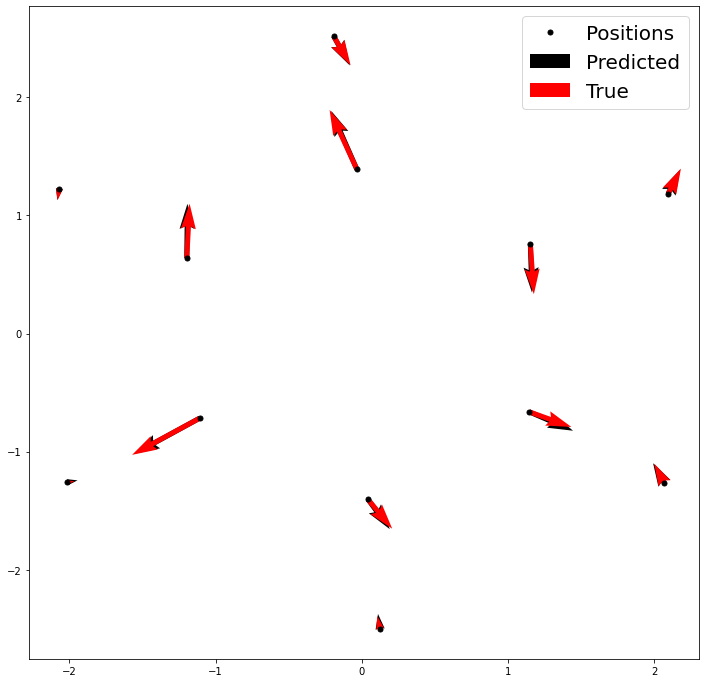

In [46]:
from matplotlib import pyplot as plt
plt.figure(figsize=(12, 12))

plt.plot(
    r[:, 0],
    r[:, 1],
    '.k',
    markersize=10,
)

plt.quiver(
    r[:, 0],
    r[:, 1],
    pred[:, 0].detach().numpy(), 
    pred[:, 1].detach().numpy()
)

plt.quiver(
    r[:, 0], 
    r[:, 1], 
    forces[:, 0], 
    forces[:, 1],
    color='red'
)

plt.legend(['Positions', 'Predicted', 'True'], prop={'size': 20})
plt.show()

## Geometric Structure Prediction

As a second exmaple, we will build a network that directly predicts positions in an equivariant fashion. Since we don't have access to a data set with relaxed strucutres, for illustration purposes we'll just ask the network to predict the input positions (a problem with a rather trivial solution). 

First, let's update the loss function in our config since we now want to train to positions instead of forces.

In [47]:
config.update({'loss_coeffs': {'pos': 1.0}})

{'loss_coeffs'}

In [48]:
config.loss_coeffs

{'pos': 1.0}

We will rebuild the trainer since we updated the loss function: 

In [49]:
if config.wandb:
    from nequip.train.trainer_wandb import TrainerWandB
    trainer = TrainerWandB(model=None, **dict(config))

else:
    from nequip.train.trainer import Trainer
    trainer = Trainer(model=None, **dict(config))

Torch device: cpu
* Initialization
append: false
atomic_weight_on: false
batch_size: 1
end_of_batch_callbacks: []
end_of_epoch_callbacks: []
end_of_train_callbacks: []
exclude_keys: []
final_callbacks: []
init_callbacks: []
kwargs:
  BesselBasis_trainable: true
  PolynomialCutoff_p: 6
  compile_model: true
  conv_to_output_hidden_irreps_out: 8x0e
  dataset: npz
  dataset_extra_fixed_fields:
    r_max: 4.0
  dataset_file_name: ./tutorial_data/benzene_ccsd_t-train.npz
  feature_irreps_hidden: 8x0o + 8x0e + 8x1o + 8x1e
  irreps_edge_sh: 0e + 1o
  key_mapping:
    E: total_energy
    F: forces
    R: pos
    z: atomic_numbers
  logfile: null
  nonlinearity_type: gate
  npz_fixed_field_keys:
  - atomic_numbers
  num_basis: 8
  num_layers: 3
  optimzer_params:
    amsgrad: true
    betas: !!python/tuple
    - 0.9
    - 0.999
    eps: 1.0e-08
    weight_decay: 0
  r_max: 4.0
  resnet: false
  screen: false
  wandb: false
  workdir: ./results/tutorial/tutorial
learning_rate: 0.01
loader_params

We will again set the data set for the trainer

In [50]:
trainer.set_dataset(dataset)

Now it's again time to build a model. We will now directly predict an equivariant quantity. We keep the core of the network the same, all we change is the output irreps, which we change to ```1x1o```, an odd vector. 

In [51]:
def DirectPositionsModel(allowed_species, **kwargs):
    """
    A model the predicts direct, equivariant positions of the relaxed structure. 

    Example input for each class
      - OneHotAtomEncoding {'allowed_species': array([1, 6, 8]), 'num_species': None, 'set_features': True}
      - SphericalHarmonicEdgeAttrs {'set_node_features': False, 'l_max': 1}
      - RadialBasisEdgeEncoding {'basis': BesselBasis(), 'cutoff': PolynomialCutoff()}
      - AtomwiseLinear {'field': 'node_features', 'out_field': None, 'irreps_out': '1x0e'}
      - ConvNet {'convolution': <class 'nequip.nn._interaction_block.InteractionBlock'>, 'num_layers': 2,
        'resnet': False, 'nonlinearity_type': 'norm', 'nonlinearity_kwargs': {},
        'feature_irreps_hidden': '16x0o + 16x0e + 16x1o + 16x1e + 16x2o + 16x2e',}
      - AtomwiseLinear
        {'field': 'node_features', 'out_field': None, 'irreps_out': '1x0e'}
    """

    logging.debug("Start building the network model")
    share_params = dict(allowed_species=allowed_species, **kwargs)

    # select the parameters needed for BesselBasis
    basis, _ = instantiate(
        cls_name=BesselBasis,
        prefix="BesselBasis",
        all_args=share_params,
    )
    cutoff, _ = instantiate(
        cls_name=PolynomialCutoff,
        prefix="PolynomialCutoff",
        all_args=share_params,
    )

    return SequentialGraphNetwork.from_parameters(
        shared_params=share_params,
        layers={
            # -- Encode --
            "one_hot": OneHotAtomEncoding,
            "spharm_edges": SphericalHarmonicEdgeAttrs,
            "radial_basis": (
                RadialBasisEdgeEncoding,
                dict(
                    basis=basis,
                    cutoff=cutoff,
                ),
            ),
            # -- Embed features --
            "feature_embedding": AtomwiseLinear,
            # -- ConvNet --
            "convnet": ConvNet,
            "output_hidden_to_vector": (
                AtomwiseLinear,
                dict(irreps_out="1x1o", out_field="pos"),
            )
        },
    )

We build the model 

In [52]:
direct_positions_model = DirectPositionsModel(allowed_species=allowed_species, **dict(config))
logging.info("Successfully built the network...")

Successfully built the network...


We will also increase the maximum number of epochs since this network trains a bit faster: 

In [53]:
trainer.model = direct_positions_model
trainer.max_epochs = 50 

And we train again. This time, ```pos_mae``` is the one to watch: 

In [54]:
trainer.train()

Number of weights: 2792
! Starting training ...

Training
# Epoch batch          pos_mae             loss
      1     5            1.012            1.346
      1    10            1.005            1.337
      1    15            0.923            1.346
      1    20            0.838            1.034
      1    25            0.562            0.629

Validation
# Epoch batch          pos_mae             loss
      1     5            0.332            0.269


  Train      # Epoch     wall       LR pos_rmse  pos_mae     loss
! Train            1    1.131     0.01      nan    0.863    1.160
  Validation # Epoch     wall       LR pos_rmse  pos_mae     loss
! Validation       1    1.131     0.01      nan    0.383    0.311
! Best model        1    0.311

Training
# Epoch batch          pos_mae             loss
      2     5            0.184            0.072
      2    10            0.216            0.086
      2    15            0.157            0.044
      2    20            0.079            0.012

  Validation # Epoch     wall       LR pos_rmse  pos_mae     loss
! Validation      12   12.706     0.01      nan    0.065    0.008

Training
# Epoch batch          pos_mae             loss
     13     5            0.085            0.011
     13    10            0.064            0.008
     13    15            0.058            0.005
     13    20            0.046            0.004
     13    25            0.059            0.005

Validation
# Epoch batch          pos_mae             loss
     13     5            0.106            0.016


  Train      # Epoch     wall       LR pos_rmse  pos_mae     loss
! Train           13   13.557     0.01      nan    0.064    0.008
  Validation # Epoch     wall       LR pos_rmse  pos_mae     loss
! Validation      13   13.557     0.01      nan    0.090    0.015

Training
# Epoch batch          pos_mae             loss
     14     5            0.089            0.013
     14    10            0.097            0.016
     14    15            0.041            

! Train           24   26.271     0.01      nan    0.045    0.004
  Validation # Epoch     wall       LR pos_rmse  pos_mae     loss
! Validation      24   26.271     0.01      nan    0.053    0.006

Training
# Epoch batch          pos_mae             loss
     25     5            0.028            0.001
     25    10            0.036            0.002
     25    15            0.087            0.012
     25    20            0.028            0.001
     25    25            0.056            0.005

Validation
# Epoch batch          pos_mae             loss
     25     5            0.039            0.003


  Train      # Epoch     wall       LR pos_rmse  pos_mae     loss
! Train           25   27.429     0.01      nan    0.048    0.004
  Validation # Epoch     wall       LR pos_rmse  pos_mae     loss
! Validation      25   27.429     0.01      nan    0.038    0.003
! Best model       25    0.003

Training
# Epoch batch          pos_mae             loss
     26     5            0.069           

! Train           36   39.998     0.01      nan    0.027    0.001
  Validation # Epoch     wall       LR pos_rmse  pos_mae     loss
! Validation      36   39.998     0.01      nan    0.039    0.003

Training
# Epoch batch          pos_mae             loss
     37     5            0.023            0.001
     37    10            0.034            0.002
     37    15            0.052            0.004
     37    20            0.021            0.001
     37    25            0.029            0.002

Validation
# Epoch batch          pos_mae             loss
     37     5            0.030            0.002


  Train      # Epoch     wall       LR pos_rmse  pos_mae     loss
! Train           37   40.853     0.01      nan    0.027    0.001
  Validation # Epoch     wall       LR pos_rmse  pos_mae     loss
! Validation      37   40.853     0.01      nan    0.031    0.002
! Best model       37    0.002

Training
# Epoch batch          pos_mae             loss
     38     5            0.023           

     48     5            0.013            0.000


  Train      # Epoch     wall       LR pos_rmse  pos_mae     loss
! Train           48   50.489     0.01      nan    0.022    0.001
  Validation # Epoch     wall       LR pos_rmse  pos_mae     loss
! Validation      48   50.489     0.01      nan    0.032    0.002

Training
# Epoch batch          pos_mae             loss
     49     5            0.026            0.001
     49    10            0.015            0.000
     49    15            0.020            0.001
     49    20            0.016            0.000
     49    25            0.022            0.001

Validation
# Epoch batch          pos_mae             loss
     49     5            0.025            0.001


  Train      # Epoch     wall       LR pos_rmse  pos_mae     loss
! Train           49   51.582     0.01      nan    0.019    0.001
  Validation # Epoch     wall       LR pos_rmse  pos_mae     loss
! Validation      49   51.582     0.01      nan    0.028    0.001

Training
# Ep

Again, it's time to predict and visualize: 

In [55]:
pred = direct_positions_model(AtomicData.to_AtomicDataDict(data))

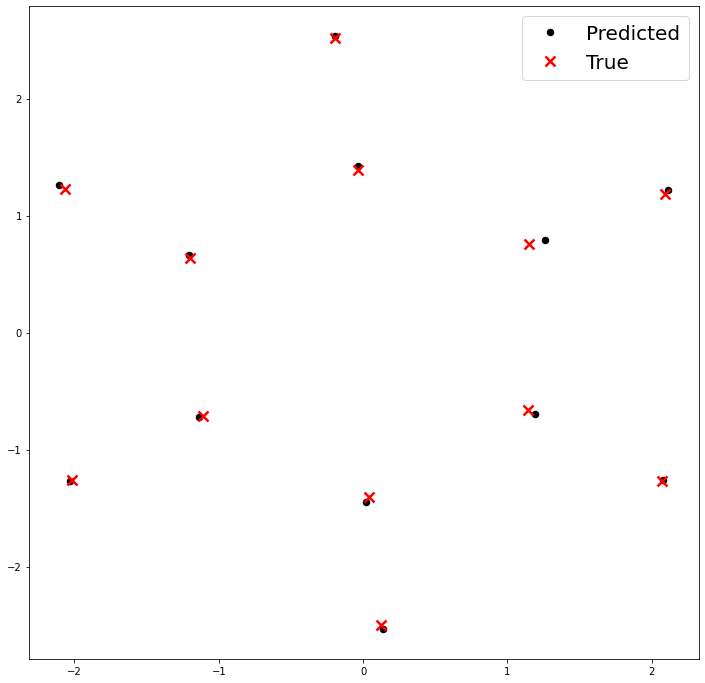

In [56]:
plt.figure(figsize=(12, 12))

plt.plot(
    pred['pos'].detach().numpy()[:, 0],
    pred['pos'].detach().numpy()[:, 1],
    '.k',
    markersize=10,
    markeredgewidth=2.5
)


plt.plot(
    r[:, 0],
    r[:, 1],
    'xr',
    markersize=10,
    markeredgewidth=2.5
)


plt.legend(['Predicted', 'True'], prop={'size': 20})
plt.show()

Seems like with only a few epochs, the network has learned about its structure. We can recognize the particular symmetry of the Benzene molecule. 

This concludes our tutorial, if you have questions, please don't hesitate to reach out at batzner@g.harvard.edu